In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import polars as pl
import lightgbm as lgb
import joblib
from lightgbm import LGBMRegressor

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)

polars.config.Config

In [2]:
multi_index = ['date_id', 'time_id', 'symbol_id']
feature_col = [f'feature_{i:02d}' for i in range(79)]
most_na_feat = ['feature_21', 'feature_26', 'feature_27', 'feature_31']

weight = ['weight']
target = ['responder_6']
end_date = 249
interest_col = multi_index + feature_col + weight + target

In [3]:
df = (pl.scan_parquet('data/train.parquet')
      .select(interest_col).drop(most_na_feat)
      .filter((pl.col('date_id')>=250) & (pl.col('date_id')<500) )
      .sort(['date_id', 'time_id','symbol_id', ])
      .collect())

df.tail()

date_id,time_id,symbol_id,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,weight,responder_6
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
499,848,30,1.311274,-0.894374,1.894025,1.777402,-1.160714,-0.148531,0.228083,-0.327251,0.129195,81,2,534,-0.322668,-0.017103,-0.262526,0.2894,0.650152,0.283905,0.230815,2.331875,0.499385,-0.193296,0.725144,0.775496,1.582501,-0.656954,0.606807,0.202113,1.325532,-0.075925,1.440143,1.442386,-0.314346,-0.203555,-0.145144,-0.601426,0.951292,1.027035,0.502316,0.303517,1.14881,0.266946,0.521387,-0.01036,-0.003355,-0.058704,-1.594733,0.947167,-0.225119,0.509373,-0.506668,-0.272231,-0.582405,0.762738,-0.024814,-0.140074,-0.128255,-0.212953,-0.29234,-0.52372,-0.443415,-0.465644,1.895874,-0.26525,-0.171657,-0.572105,-0.040254,0.174453,0.222555,-0.400748,-0.320127,-0.228063,-0.34768,-0.422228,-0.332906,1.537676,0.969511
499,848,33,1.514527,-0.889597,1.847042,1.750143,-0.860073,-0.171633,0.246361,-0.328016,0.177686,11,7,76,0.002288,-0.100881,0.076481,0.24215,0.669266,0.545175,-0.285243,2.092442,0.844599,0.455957,1.563596,0.280926,0.117275,-0.869537,0.315024,0.382252,0.831477,-0.420247,1.170804,1.122818,1.295369,0.123351,0.369036,0.402333,0.720028,0.895717,1.157884,1.448565,1.41578,-0.102379,0.774513,0.38405,0.024109,0.426491,-0.291213,-0.005939,1.135808,0.834223,-1.045793,-0.203057,0.298278,0.075476,0.327036,-0.033241,0.298047,-0.212953,-0.269743,-0.640997,-0.42489,0.090099,1.771076,-0.140496,0.122688,-0.120895,0.245351,-0.209682,0.319865,-0.387531,-0.334167,-0.233983,-0.325119,-0.215832,-0.131751,1.518297,0.087618
499,848,34,1.819305,-0.647914,1.778981,1.672205,-0.384032,-0.197901,0.280644,-0.282307,0.188068,42,5,150,0.057875,-0.011079,-0.154985,-0.527841,0.20299,-0.261604,1.28246,-1.7319,-0.305669,-0.625708,-1.245957,-0.490363,-0.6159,1.403845,-0.535602,-0.498567,0.879451,0.518652,0.537576,1.027046,0.576428,0.599112,0.749792,0.119438,-0.861054,1.255323,0.755409,-0.812095,-0.281411,-0.148231,-0.18676,0.677441,0.665941,1.383216,1.473487,1.771299,1.582944,0.949259,-0.886647,0.266842,-0.240559,-0.670787,1.18483,3.440902,2.148732,-0.212953,-0.031091,0.334972,-0.019838,1.320655,-2.526896,-0.192308,-0.144814,-0.313928,0.286432,0.156241,-0.009232,0.246803,0.412694,4.057263,3.963672,0.767732,0.657952,0.850895,1.05851
499,848,36,1.477508,-0.337082,2.192112,1.683748,-1.222171,-0.28357,0.285032,-0.443169,0.179608,26,12,158,-0.434802,-0.629621,-0.523148,4.626356,6.08392,9.615068,4.248285,1.480826,-1.261833,-1.05223,0.990769,-0.634391,-0.699837,-1.416092,5.195201,7.736139,1.203991,0.340272,1.222053,1.560964,1.473051,0.279474,0.615571,-0.667627,0.466401,0.344747,-1.417414,1.013434,-2.512226,-1.623386,-1.31168,-0.14021,0.26385,0.190497,1.023436,2.453119,1.741818,-0.835535,-2.464447,-1.835441,-0.579309,-1.147846,-0.567203,0.007473,-0.154159,-0.212953,1.128539,2.30438,2.236297,3.395443,-0.257348,-0.463107,-0.352719,-0.858124,-0.570437,-0.376604,-0.302231,-0.280501,-0.356199,-0.274239,-0.2994

In [4]:
# X = df.drop(['date_id', 'time_id', target]).to_pandas()
X = X = df.drop(multi_index+weight+target).to_pandas()
y = df[target].to_pandas()
sample_weight = df[weight].to_pandas().values.flatten()

In [5]:
print(X.columns)

Index(['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04',
       'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_22', 'feature_23', 'feature_24', 'feature_25',
       'feature_28', 'feature_29', 'feature_30', 'feature_32', 'feature_33',
       'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38',
       'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43',
       'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48',
       'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53',
       'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58',
       'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63',
       'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68',

In [6]:
parm = {'n_estimators':1000, 'max_depth':6, 'num_leaves':64, 'learning_rate':0.05,
        'colsample_bytree':0.5, 'importance_type':'gain', 'boosting_type':'dart' ,'random_state':0, 'n_jobs':-1}
model = LGBMRegressor(**parm)

In [7]:
model.fit(X, y, sample_weight=sample_weight)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.277835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18403
[LightGBM] [Info] Number of data points in the train set: 4318014, number of used features: 75
[LightGBM] [Info] Start training from score -0.009813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

LGBMRegressor(boosting_type='dart', colsample_bytree=0.5,
              importance_type='gain', learning_rate=0.05, max_depth=6,
              n_estimators=1000, n_jobs=-1, num_leaves=64, random_state=0)

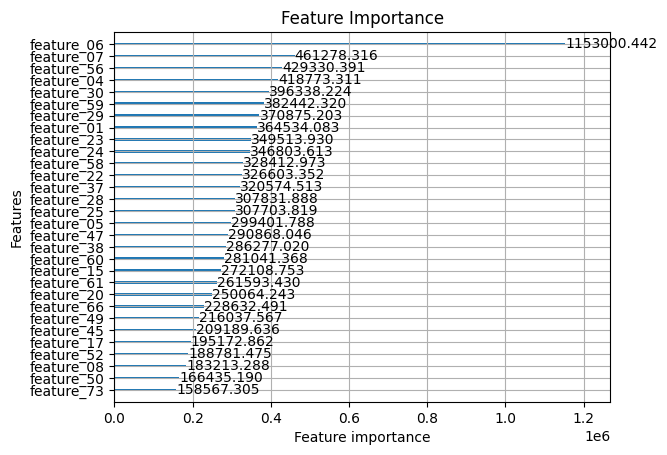

In [8]:
lgb.plot_importance(model, max_num_features=30, importance_type='gain')  # 或 'gain'
plt.title("Feature Importance")
plt.show()

In [9]:
data = {
    'model' : model, 
    'feature' : X.columns.tolist(),
    'parmaters' : parm
    }

joblib.dump(data, './model/lgbm3-2_d6_n1000.pkl')

['./model/lgbm3-2_d6_n1000.pkl']